# Download data and import libraries

# Review 2  Web Mining

In [157]:
%matplotlib inline 

import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [40]:
# load data    
with open('df_data.pickle', 'rb') as f:
    df_data = pickle.load(f)
df_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,Revenue,SpecialDay_0.2,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,0.000000,0.20,0.0,2,False,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0.0,0,0.0,64.000000,0.10,0.0,2,False,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.0,0,0.0,0.000000,0.20,0.0,2,False,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0.0,0,0.0,2.666667,0.14,0.0,2,False,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0.0,0,0.0,627.500000,0.05,0.0,2,False,0,...,0,1,0,0,0,0,0,0,1,1


# Given purchasing behavior data for a complete dataset, generate user-behavior clusters. Answer the following questions based on the analysis:

1. How many clusters exist and what are the significant differences among them with respect to size and purchase ratio?
2. Conduct an in-depth analysis of each cluster, considering variations in features, and identify specific behaviors associated with each cluster.




In [41]:
#selecting data before transformations for supervised learning
df_clustering = df_data.copy()
df_clustering.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated_Duration', 'ExitRates',
       'PageValues', 'Month', 'Revenue', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7',
       'OperatingSystems_8', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12',
       'TrafficType_13', 'TrafficType_14', 'TrafficType_15', 'TrafficType_16',
       'TrafficType_17', 'TrafficType_18', 'TrafficType_19', 'TrafficType_2',
       'TrafficType_20', 'TrafficType_3', 'Traffic

In [42]:
df_clustering['Revenue'].value_counts()

False    10137
True      1705
Name: Revenue, dtype: int64

In [43]:
#from helper functions

def return_feature_rank_from_RF(X_train,y_train, features): 
# Build a forest and compute the impurity-based feature importances
    forest = ExtraTreesClassifier(n_estimators=20,random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return (indices,importances)

Feature ranking:
1. PageValues (0.318518)
2. ProductRelated_Duration (0.092071)
3. ExitRates (0.088754)
4. Administrative_Duration (0.061387)
5. Administrative (0.061031)
6. Month (0.055146)
7. Informational_Duration (0.032119)
8. Informational (0.031637)
9. Weekend_True (0.020194)
10. Region_3 (0.018343)
11. Browser_2 (0.016280)
12. TrafficType_2 (0.015153)
13. VisitorType_Returning_Visitor (0.013480)
14. OperatingSystems_2 (0.013266)
15. Region_4 (0.012047)
16. Region_2 (0.011865)
17. Region_6 (0.010093)
18. OperatingSystems_3 (0.009425)
19. Region_7 (0.009333)
20. Browser_4 (0.007884)
21. TrafficType_4 (0.007584)
22. TrafficType_3 (0.007192)
23. Region_9 (0.006816)
24. Region_8 (0.006439)
25. OperatingSystems_4 (0.006007)
26. Browser_5 (0.005830)
27. TrafficType_8 (0.005562)
28. TrafficType_10 (0.005432)
29. TrafficType_6 (0.005235)
30. Region_5 (0.004904)
31. TrafficType_5 (0.004080)
32. TrafficType_11 (0.004072)
33. TrafficType_13 (0.003702)
34. Browser_10 (0.003334)
35. TrafficTy

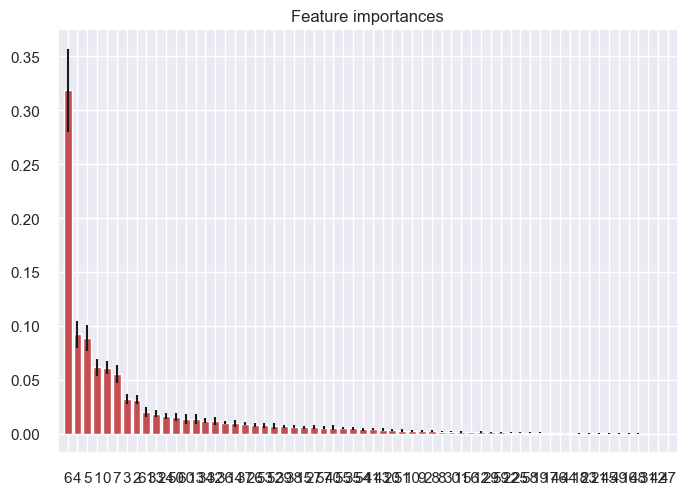

In [44]:
#Calculate, print, and plot the feature importances, in descending order of importance.
y = df_clustering['Revenue'].values
del df_clustering['Revenue']

features = list(df_clustering.columns)
X = df_clustering.values

indices, importances = return_feature_rank_from_RF(X,y, features)

##### It is reasonable to look at only features with importance > 0.030

In [104]:
idx = list(np.where(importances > 0.030)[0])
selected_columns = [f for f in features if features.index(f) in idx]

print("Selected features:")
selected_columns

Selected features:


['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated_Duration',
 'ExitRates',
 'PageValues',
 'Month']

In [108]:
X_train = df_data[selected_columns].values
y_train = y


## Clustering
##### Further reducing dimentions

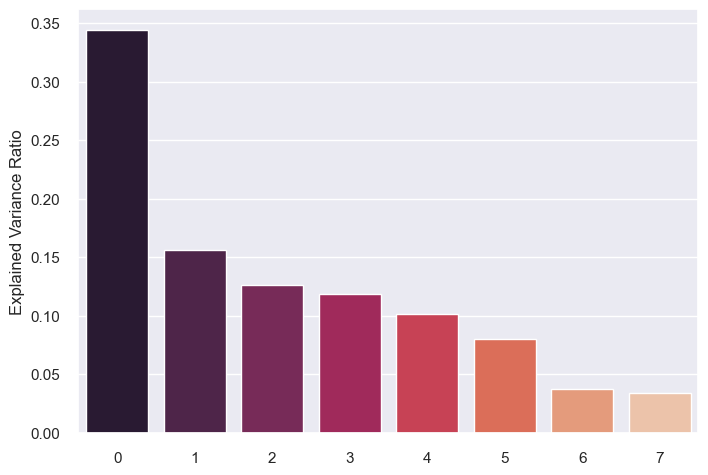

In [47]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


pca = PCA()
pca.fit(X_scaled)
expl_var = pca.explained_variance_ratio_
x = list(range(expl_var.shape[0]))

sns.barplot(x=x, y=expl_var, palette="rocket")
plt.ylabel("Explained Variance Ratio")
plt.show()

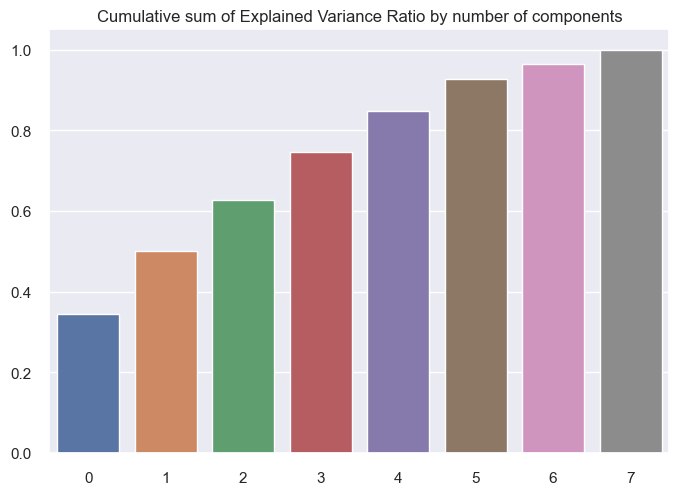

In [48]:
y = expl_var.cumsum()
sns.barplot(x=x, y=y)
plt.title("Cumulative sum of Explained Variance Ratio by number of components")
plt.show()

In [102]:
selected_n_components = 5 #since total explained variance ratio is >85%
pca = PCA(n_components=selected_n_components)
X_red = pca.fit_transform(X_scaled)

print(X_red.shape)

(11842, 5)


##### Clustering reduced feature data

Using $k$-means clustering with $k \in [1, 20]$ to the reduced features data. 
Visualize the associated distortion scores and computational times.


c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

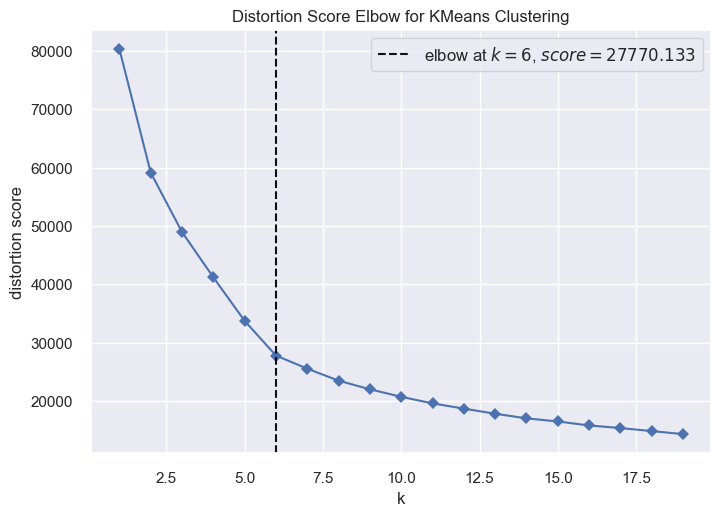

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,20), timings=False
)

visualizer.fit(X_red)    # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**The “elbow” method shows that the optimal number of clusters  is 6.**

In [51]:
n = 6
# Instantiate the clustering model
clusters = KMeans(n_clusters = n, random_state=2)
# Assign the points in the reduced dataset to clusters
C_vals = np.array(clusters.fit_predict(X_red))

c:\Users\ayuar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
df_clusters = df_data[selected_columns + ['VisitorType_Returning_Visitor', 'Revenue']].copy()
df_clusters['ClusterID'] = C_vals
df_clusters.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,VisitorType_Returning_Visitor,Revenue,ClusterID
0,0,0.0,0,0.0,0.000000,0.20,0.0,2,1,False,4
1,0,0.0,0,0.0,64.000000,0.10,0.0,2,1,False,3
2,0,0.0,0,0.0,0.000000,0.20,0.0,2,1,False,4
3,0,0.0,0,0.0,2.666667,0.14,0.0,2,1,False,4
4,0,0.0,0,0.0,627.500000,0.05,0.0,2,1,False,3


## Cluster analysis:

In [53]:
df_tmp = df_clusters.copy()
df_tmp["Cluster size"] = df_tmp.index
df_tmp['Purchase ratio'] = df_tmp['Revenue']
df_tmp1 = df_tmp.groupby('ClusterID').agg({"Cluster size": "count",
                                               "Purchase ratio": "sum",
                                           'VisitorType_Returning_Visitor': "mean"
                                              })

print("Total number of records:", len(df_tmp))
df_tmp1["Purchase ratio"] = df_tmp1["Purchase ratio"]/len(df_tmp)
df_tmp1 = df_tmp1.reset_index()
df_tmp1

Total number of records: 11842


,ClusterID,Cluster size,Purchase ratio,VisitorType_Returning_Visitor
0,0,658,0.014862,0.902736
1,1,3640,0.040534,0.792857
2,2,695,0.043996,0.716547
3,3,4039,0.019591,0.899975
4,4,1309,0.000760,0.948816
5,5,1501,0.024236,0.852099


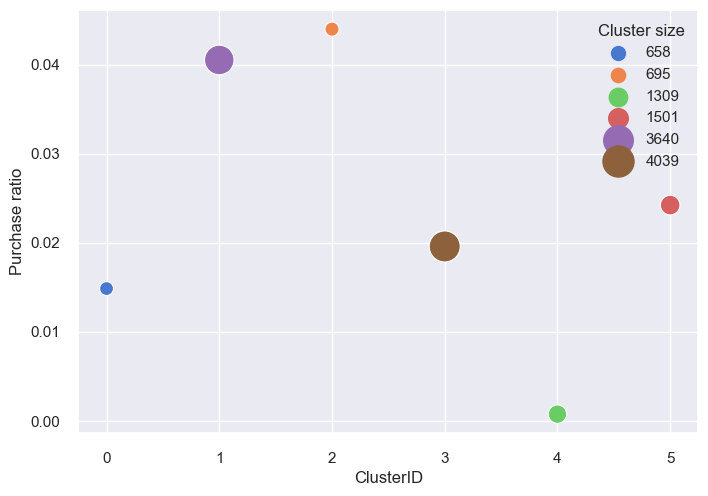

In [54]:
sns.set_theme(style="darkgrid")
sns.scatterplot(
    data=df_tmp1, x="ClusterID", y="Purchase ratio", 
    hue="Cluster size", size="Cluster size",
    sizes=(100, 500), hue_norm=(0, 7), 
    palette="muted", legend="full"
)
plt.show()

In [55]:
df_clusters[['ClusterID',
             'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
             'Revenue']].groupby('ClusterID').describe().T

ClusterID                                0            1            2  \
Administrative_Duration count   658.000000  3640.000000   695.000000   
                        mean    169.802607    30.673004    72.788721   
                        std     156.716933    45.864148    98.763333   
                        min       0.000000     0.000000     0.000000   
                        25%      53.912500     0.000000     0.000000   
                        50%     133.466667     0.000000    44.016667   
                        75%     241.812500    52.500000   101.000000   
                        max     828.052632   284.000000   739.209195   
Informational_Duration  count   658.000000  3640.000000   695.000000   
                        mean    268.000905     4.930961    11.464408   
                        std     149.334968    19.489045    34.636309   
                        min       9.500000     0.000000     0.000000   
                        25%     151.354167     0.000000     0.000000   
                        50%     239.850000     0.000000     0.000000   
                        75%     360.125000     0.000000     0.000000   
                        max     689.833333   249.500000   339.500000   
ProductRelated_Duration count   658.000000  3640.000000   695.000000   
                        mean   2444.833455  1083.600099  1147.834817   
                        std    1953.845565  1227.022514  1023.424072   
                        min      17.000000     0.000000     4.000000   
                        25%     911.716964   251.672917   492.950000   
                        50%    1883.751786   654.958333   856.416667   
                        75%    3675.656447  1423.801190  1437.300000   
                        max    8205.687940  8068.742154  7793.158685   

ClusterID                                3            4            5  
Administrative_Duration count  4039.000000  1309.000000  1501.000000  
                        mean     25.766911     1.301031   267.757033  
                        std      45.468451    12.713900   162.611761  
                        min       0.000000     0.000000    27.000000  
                        25%       0.000000     0.000000   152.875000  
                        50%       0.000000     0.000000   226.090000  
                        75%      37.000000     0.000000   335.119048  
                        max     306.000000   256.500000   827.200000  
Informational_Duration  count  4039.000000  1309.000000  1501.000000  
                        mean      5.328632     0.083422    18.329548  
                        std      22.583120     1.401596    36.418474  
                        min       0.000000     0.000000     0.000000  
                        25%       0.000000     0.000000     0.000000  
                        50%       0.000000     0.000000     0.000000  
                        75%       0.000000     0.000000    19.750000  
                        max     255.000000    34.200000   246.800000  
ProductRelated_Duration count  4039.000000  1309.000000  1501.000000  
                        mean    736.719410    52.700614  1860.121869  
                        std     831.660919   141.649968  1662.890013  
                        min       0.000000     0.000000     0.000000  
                        25%     183.750000     0.000000   632.250000  
                        50%     454.000000     0.000000  1386.350000  
                        75%     985.750000    47.000000  2531.060479  
                        max    6951.972222  1787.500000  8147.111565

**Cluster 0:** This cluster has the highest number of observations, and its visitors tend to have a relatively low duration of administrative, informational, and product-related activities on the website. They have a higher likelihood of not having any informational or product-related activities on the site.

**Cluster 1:** This cluster has the second-highest number of observations, and its visitors tend to have a high duration of product-related activities on the website, but relatively low durations of administrative and informational activities.

**Cluster 2:** This cluster has the third-highest number of observations, and its visitors tend to have a high duration of informational activities on the website, but relatively low durations of administrative and product-related activities.

**Cluster 3:** This cluster has a relatively low number of observations compared to the other clusters, and its visitors tend to have a high duration of administrative activities on the website, but relatively low durations of informational and product-related activities.

**Cluster 4:** This cluster has the second-lowest number of observations, and its visitors tend to have a high duration of administrative and product-related activities on the website, but relatively low durations of informational activities.

**Cluster 5:** This cluster has the lowest number of observations, and its visitors tend to have a very low duration of all three types of activities on the website.

Overall, we can see that the clusters exhibit significant differences in the duration of their activities on the website, with some clusters showing a high duration of a particular activity type and low durations of others. This information can help businesses tailor their website design and content to better cater to the needs and preferences of visitors in different clusters, ultimately leading to better user engagement and higher conversion rates.

In [56]:
df_clusters[['ClusterID','ExitRates',
       'PageValues', 'Month', 'VisitorType_Returning_Visitor',
             'Revenue']].groupby('ClusterID').describe().T

ClusterID                                     0            1           2  \
ExitRates                     count  658.000000  3640.000000  695.000000   
                              mean     0.021462     0.029881    0.016685   
                              std      0.013977     0.020645    0.012969   
                              min      0.000000     0.000000    0.000000   
                              25%      0.011842     0.014809    0.007407   
                              50%      0.018267     0.025000    0.013377   
                              75%      0.027772     0.040000    0.022882   
                              max      0.104082     0.137427    0.075000   
PageValues                    count  658.000000  3640.000000  695.000000   
                              mean     7.374168     1.368747   47.052870   
                              std     12.337076     4.471564   15.403333   
                              min      0.000000     0.000000   21.471420   
                              25%      0.000000     0.000000   33.612658   
                              50%      0.000000     0.000000   44.711034   
                              75%     10.131372     0.000000   57.777049   
                              max     79.484039    27.777259   85.752859   
Month                         count  658.000000  3640.000000  695.000000   
                              mean     8.290274    10.884066    8.079137   
                              std      3.262153     1.140462    3.217085   
                              min      2.000000     5.000000    2.000000   
                              25%      5.000000    11.000000    5.000000   
                              50%     10.000000    11.000000    9.000000   
                              75%     11.000000    12.000000   11.000000   
                              max     12.000000    12.000000   12.000000   
VisitorType_Returning_Visitor count  658.000000  3640.000000  695.000000   
                              mean     0.902736     0.792857    0.716547   
                              std      0.296543     0.405314    0.450999   
                              min      0.000000     0.000000    0.000000   
                              25%      1.000000     1.000000    0.000000   
                              50%      1.000000     1.000000    1.000000   
                              75%      1.000000     1.000000    1.000000   
                              max      1.000000     1.000000    1.000000   

ClusterID                                      3            4            5  
ExitRates                     count  4039.000000  1309.000000  1501.000000  
                              mean      0.034896     0.164996     0.020232  
                              std       0.024571     0.041736     0.013920  
                              min       0.000000     0.084615     0.000000  
                              25%       0.015446     0.122222     0.010753  
                              50%       0.028571     0.200000     0.017500  
                              75%       0.050000     0.200000     0.026472  
                              max       0.128571     0.200000     0.116667  
PageValues                    count  4039.000000  1309.000000  1501.000000  
                              mean      1.170883     0.000000     4.816013  
                              std       4.186653     0.000000     8.402016  
                              min       0.000000     0.000000     0.000000  
                              25%       0.000000     0.000000     0.000000  
                              50%       0.000000     0.000000     0.000000  
                              75%       0.000000     0.000000     6.733745  
                              max      29.243250     0.000000    52.051650  
Month                         count  4039.000000  1309.000000  1501.000000  
                              mean      4.407279     7.087853     8.192538  
                            

**Cluster 0:** 
This cluster has a relatively high exit rate (mean of 0.035) compared to other clusters. The mean value of page values is also low (1.16). This cluster has visitors from all months, and most of them are returning visitors (90%).


**Cluster 1:**
This cluster has the lowest exit rate (mean of 0.020) among all clusters. The visitors in this cluster have the highest mean value of page values (4.83) compared to other clusters. Most of the visitors in this cluster are returning visitors (85%).


**Cluster 2:**
This cluster has a relatively low exit rate (mean of 0.021) compared to cluster 0 and cluster 4. The visitors in this cluster have a higher mean value of page values (7.37) compared to other clusters. Most of the visitors in this cluster are returning visitors (90%).


**Cluster 3:** 
This cluster has the lowest mean value of page values (47.05) compared to other clusters. The visitors in this cluster have a relatively low exit rate (mean of 0.017) compared to cluster 0 and cluster 4. Most of the visitors in this cluster are from the months of August, September, and October (10).


**Cluster 4:** 
This cluster has a high exit rate (mean of 0.030) compared to cluster 1 and cluster 3. The visitors in this cluster have a low mean value of page values (1.37) compared to other clusters. Most of the visitors in this cluster are from the month of November (11).


**Cluster 5:**
This cluster has a low mean value of page values (0.00), indicating that the visitors in this cluster did not make any purchases. Most of the visitors in this cluster are returning visitors (94%).

In [57]:
df_cl4 = df_clusters[df_clusters['ClusterID'] == 4]
df_cl4.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,1309.0,0.058824,0.320634,0.000000,0.000000,0.0,0.0,4.0
Administrative_Duration,1309.0,1.301031,12.713900,0.000000,0.000000,0.0,0.0,256.5
Informational,1309.0,0.015279,0.150672,0.000000,0.000000,0.0,0.0,2.0
Informational_Duration,1309.0,0.083422,1.401596,0.000000,0.000000,0.0,0.0,34.2
ProductRelated_Duration,1309.0,52.700614,141.649968,0.000000,0.000000,0.0,47.0,1787.5
ExitRates,1309.0,0.164996,0.041736,0.084615,0.122222,0.2,0.2,0.2
PageValues,1309.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Month,1309.0,7.087853,3.328234,2.000000,5.000000,5.0,11.0,12.0
VisitorType_Returning_Visitor,1309.0,0.948816,0.220457,0.000000,1.000000,1.0,1.0,1.0
ClusterID,1309.0,4.000000,0.000000,4.000000,4.000000,4.0,4.0,4.0


In [58]:
df_other = df_clusters[df_clusters['ClusterID'] != 4]
df_other.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,10533.0,2.416690,3.191093,0.0,0.000000,1.000000,4.000000,24.000000
Administrative_Duration,10533.0,74.047647,122.168706,0.0,0.000000,19.000000,99.000000,828.052632
Informational,10533.0,0.483243,1.157806,0.0,0.000000,0.000000,0.000000,14.000000
Informational_Duration,10533.0,23.857975,77.329143,0.0,0.000000,0.000000,0.000000,689.833333
ProductRelated_Duration,10533.0,1150.517668,1315.302358,0.0,269.901818,684.750000,1524.962997,8205.687940
ExitRates,10533.0,0.029032,0.021627,0.0,0.013333,0.023321,0.040000,0.137427
PageValues,10533.0,5.173666,13.267159,0.0,0.000000,0.000000,0.000000,85.752859
Month,10533.0,7.669800,3.396866,2.0,5.000000,8.000000,11.000000,12.000000
VisitorType_Returning_Visitor,10533.0,0.844204,0.362679,0.0,1.000000,1.000000,1.000000,1.000000
ClusterID,10533.0,2.340454,1.464841,0.0,1.000000,3.000000,3.000000,5.000000


Cluster  0


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


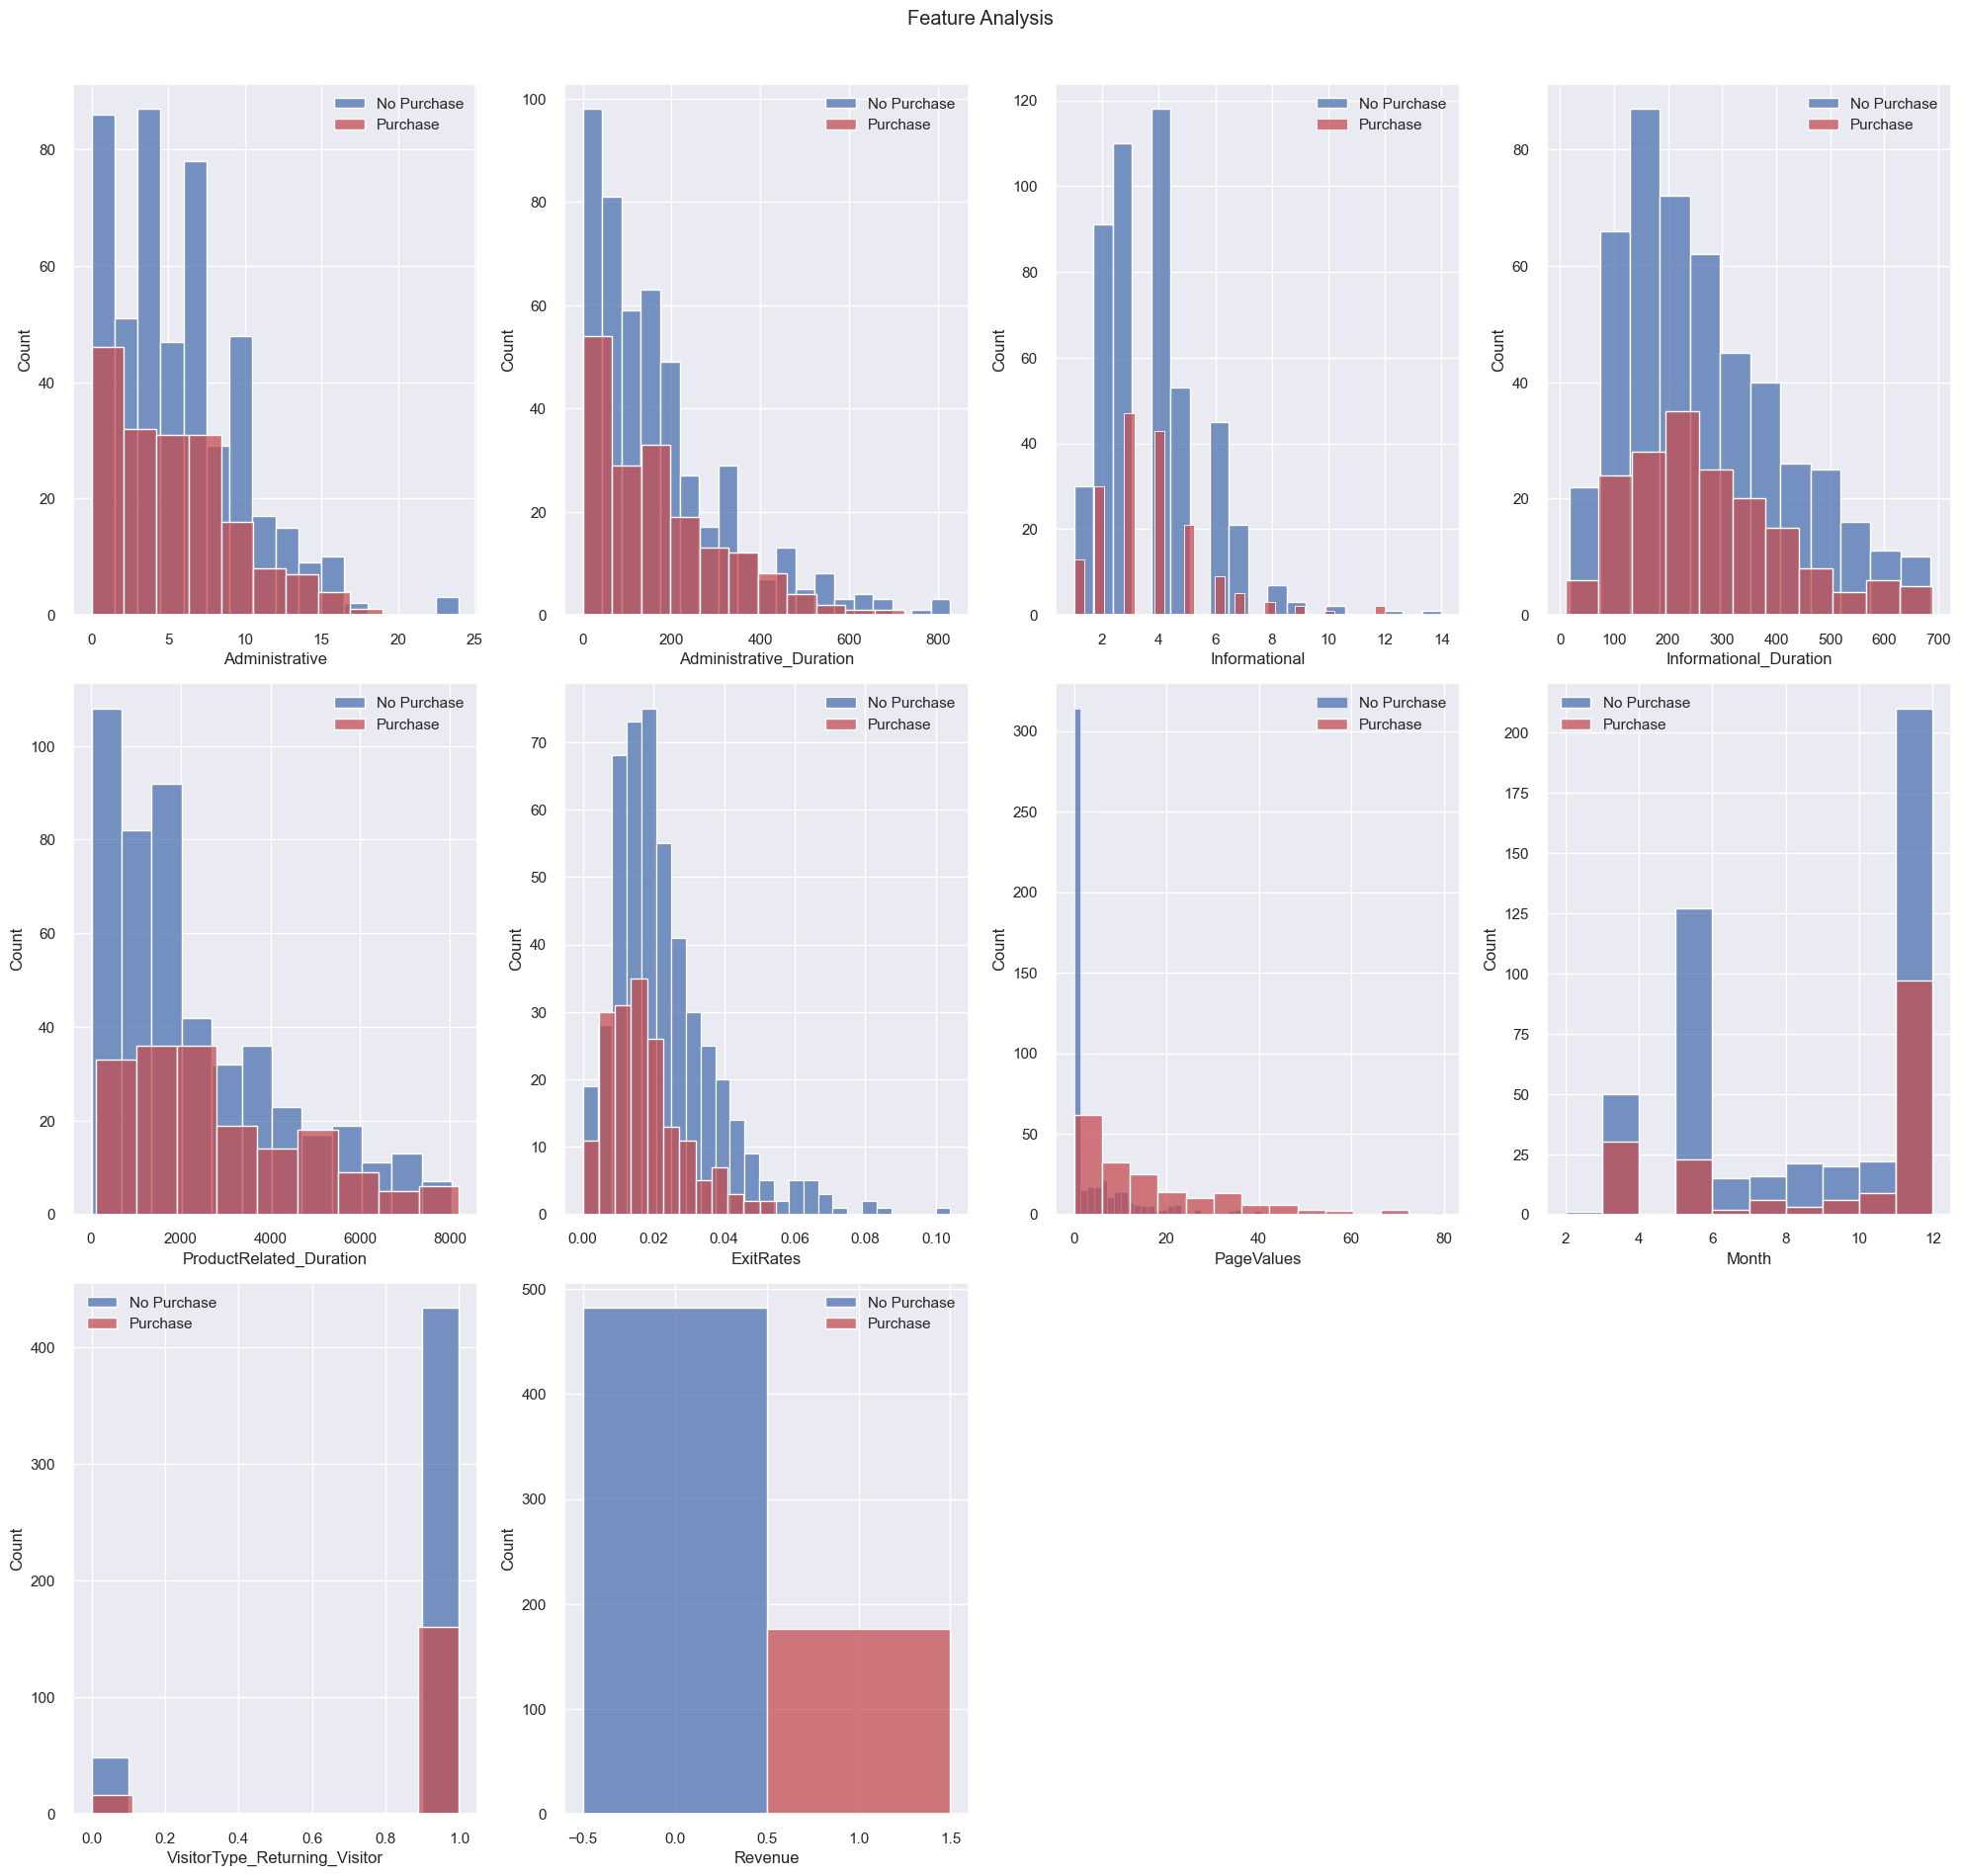

In [158]:
# Next, to analyze composition of each cluster
#Cluster 2
for i in range(1):
    print("Cluster  {}".format(i))
    result = df_clusters.loc[df_clusters['ClusterID'] == i]


    fig = plt.figure(figsize = (20, 25))
    j = 0
    for i,item in enumerate(result.columns):
        if item != "ClusterID":
            plt.subplot(4, 4, j+1)
            j += 1
            sns.histplot(result[item][result['Revenue']==False], color='b', label = 'No Purchase')
            sns.histplot(result[item][result['Revenue']==True], color='r', label = 'Purchase')
            plt.legend(loc='best')

    fig.suptitle('Feature Analysis')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

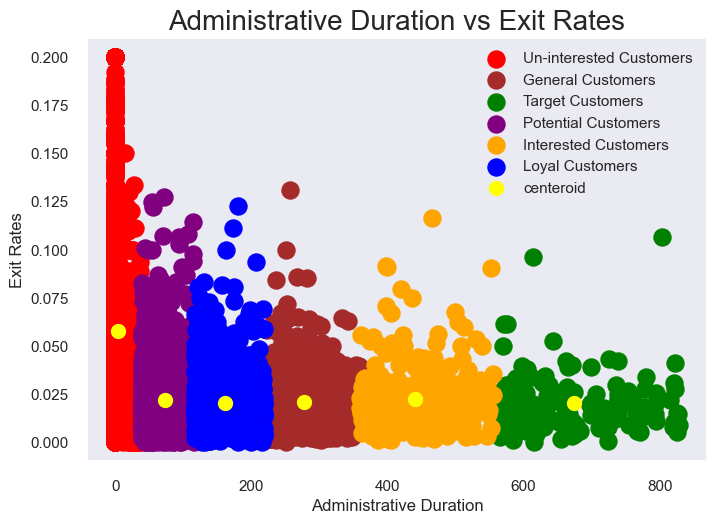

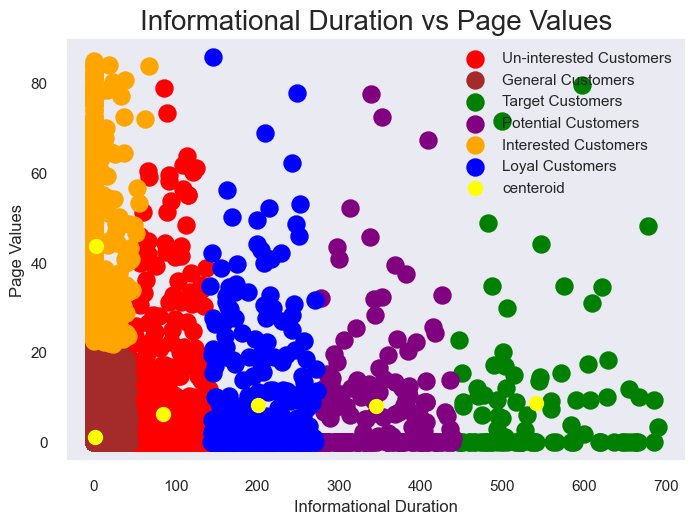

In [156]:
x = df_data.iloc[:, [1,5]].values
km = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 150, c = 'red', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 150, c = 'brown', label = 'General Customers')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 150, c = 'green', label = 'Target Customers')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 150, c = 'purple', label = 'Potential Customers')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 150, c = 'orange', label = 'Interested Customers')
plt.scatter(x[y_means == 5, 0], x[y_means == 5, 1], s = 150, c = 'blue', label = 'Loyal Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 100, c = 'yellow' , label = 'centeroid')
plt.title('Administrative Duration vs Exit Rates', fontsize = 20)
plt.grid()
plt.xlabel('Administrative Duration')
plt.ylabel('Exit Rates')
plt.legend()
plt.show()

x = df_data.iloc[:, [3,6]].values
km = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 150, c = 'red', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 150, c = 'brown', label = 'General Customers')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 150, c = 'green', label = 'Target Customers')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 150, c = 'purple', label = 'Potential Customers')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 150, c = 'orange', label = 'Interested Customers')
plt.scatter(x[y_means == 5, 0], x[y_means == 5, 1], s = 150, c = 'blue', label = 'Loyal Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 100, c = 'yellow' , label = 'centeroid')
plt.title('Informational Duration vs Page Values', fontsize = 20)
plt.grid()
plt.xlabel('Informational Duration')
plt.ylabel('Page Values')
plt.legend()
plt.show()

In [155]:
df_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,Month,Revenue,SpecialDay_0.2,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,0.000000,0.200000,0.000000,2,False,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0.0,0,0.0,64.000000,0.100000,0.000000,2,False,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0.0,0,0.0,0.000000,0.200000,0.000000,2,False,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0.0,0,0.0,2.666667,0.140000,0.000000,2,False,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0.0,0,0.0,627.500000,0.050000,0.000000,2,False,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,1783.791667,0.029031,12.241717,12,False,0,...,0,0,0,0,0,0,0,0,1,1
12326,0,0.0,0,0.0,465.750000,0.021333,0.000000,11,False,0,...,0,0,0,0,0,1,0,0,1,1
12327,0,0.0,0,0.0,184.250000,0.086667,0.000000,11,False,0,...,0,0,0,0,0,0,0,0,1,1
12328,4,75.0,0,0.0,346.000000,0.021053,0.000000,11,False,0,...,0,0,0,0,0,0,0,0,1,0


## Decision Tree


In [96]:

df_final=df_tmp.drop(["ClusterID"],axis=1)
df_final=df_final.drop(["Cluster size"],axis=1)
df_final=df_final.drop(["Purchase ratio"],axis=1)
# Import necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split dataset into features and target
X = df_final.drop(columns=["Revenue"])
y = df_final["Revenue"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create decision tree classifier and fit the model to the training data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




Accuracy: 0.8687209793161672


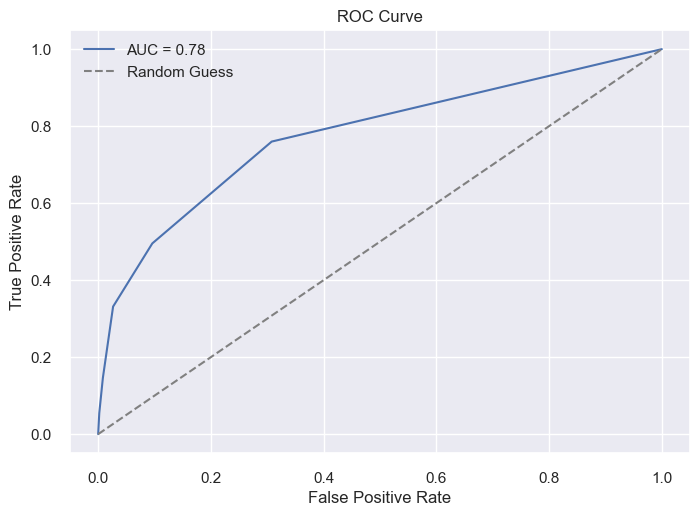

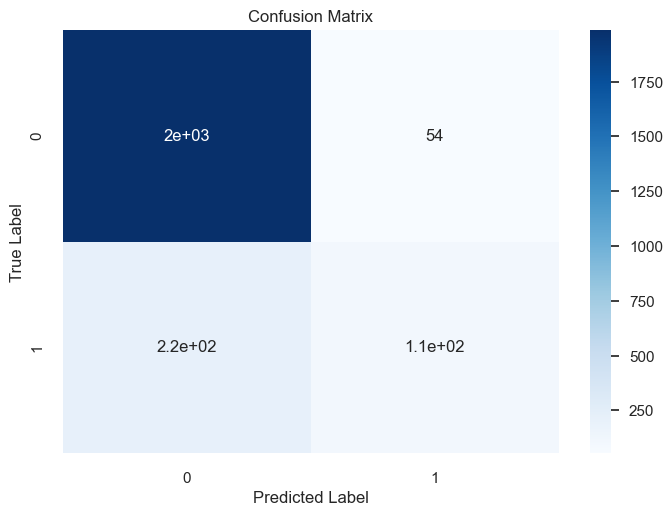

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Get predicted probabilities for the test data
y_proba = clf.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



## K-Nearest Neighbour

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load the dataset
df = df_final

# Split dataset into features and target
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create k-NN classifier and fit the model to the training data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.8843393837062051


### Plots on KNN


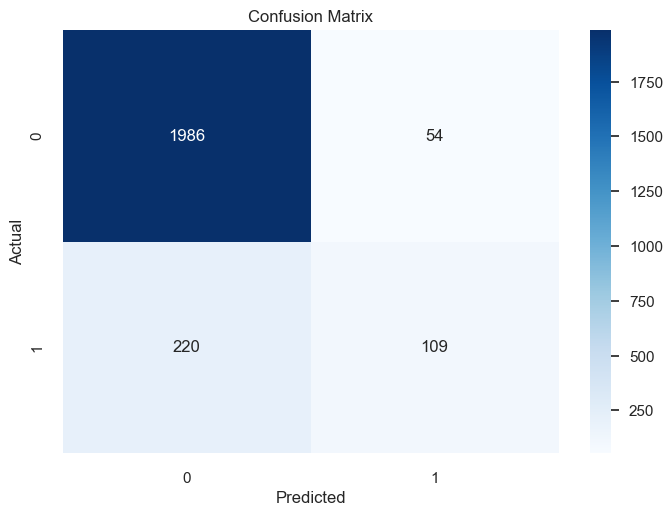

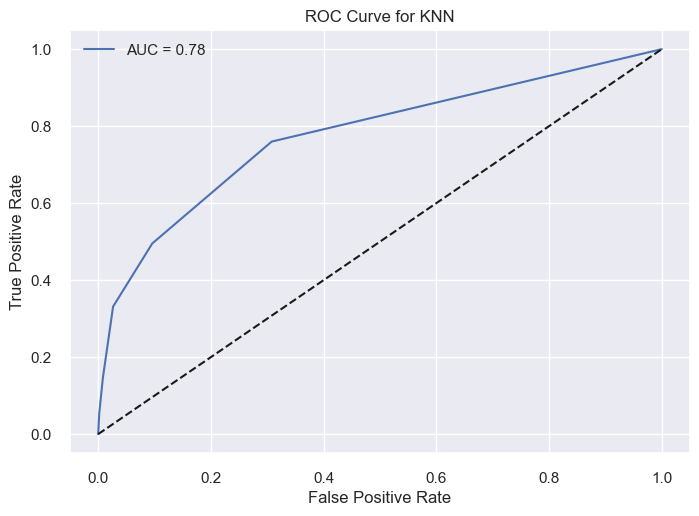

In [128]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend()
plt.show()
